In [ ]:
# Standard library imports
import os
import warnings
#warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Third-party imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from sklearn.decomposition import PCA
import gym
# First install neurogym if not already installed
import subprocess
import os
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e

import neurogym as ngym

from typing import Dict, Tuple, List
import time
from dataclasses import dataclass

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1488/1488), done.
remote: Compressing objects: 100% (373/373), done.
remote: Total 13187 (delta 1166), reused 1220 (delta 1100), pack-reused 11699 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (9972/9972), done.
/content/neurogym

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(



Training on task: PerceptualDecisionMaking-v0


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Training VANILLA RNN...
Epoch 0, Loss: 1.0036, Acc: 0.8438
Epoch 20, Loss: 0.6191, Acc: 0.8688
Epoch 40, Loss: 0.4706, Acc: 0.8625
Epoch 60, Loss: 0.4406, Acc: 0.8750
Epoch 80, Loss: 0.3923, Acc: 0.8750
Epoch 100, Loss: 0.3104, Acc: 0.9250
Epoch 120, Loss: 0.2201, Acc: 0.9187
Epoch 140, Loss: 0.1880, Acc: 0.9375
Epoch 160, Loss: 0.1679, Acc: 0.9500
Epoch 180, Loss: 0.1591, Acc: 0.9250

Training EI RNN...
Epoch 0, Loss: 1.0894, Acc: 0.0563
Epoch 20, Loss: 0.6680, Acc: 0.8812
Epoch 40, Loss: 0.4914, Acc: 0.8688
Epoch 60, Loss: 0.4808, Acc: 0.9125
Epoch 80, Loss: 0.4643, Acc: 0.8313
Epoch 100, Loss: 0.4508, Acc: 0.8313
Epoch 120, Loss: 0.4339, Acc: 0.8187
Epoch 140, Loss: 0.4037, Acc: 0.9187
Epoch 160, Loss: 0.3644, Acc: 0.8750
Epoch 180, Loss: 0.3197, Acc: 0.8438

Training on task: PerceptualDecisionMakingDelayResponse-v0

Training VANILLA RNN...


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Epoch 0, Loss: 1.1170, Acc: 0.4375
Epoch 20, Loss: 0.9698, Acc: 0.5375
Epoch 40, Loss: 0.7287, Acc: 0.5375
Epoch 60, Loss: 0.6188, Acc: 0.5875
Epoch 80, Loss: 0.5709, Acc: 0.5813
Epoch 100, Loss: 0.5436, Acc: 0.5437
Epoch 120, Loss: 0.5302, Acc: 0.5625
Epoch 140, Loss: 0.5156, Acc: 0.5250
Epoch 160, Loss: 0.5115, Acc: 0.5500
Epoch 180, Loss: 0.4972, Acc: 0.4437

Training EI RNN...
Epoch 0, Loss: 1.0981, Acc: 0.4688
Epoch 20, Loss: 1.0602, Acc: 0.0938
Epoch 40, Loss: 0.9647, Acc: 0.5188
Epoch 60, Loss: 0.7480, Acc: 0.5437
Epoch 80, Loss: 0.6268, Acc: 0.6000
Epoch 100, Loss: 0.5798, Acc: 0.5312
Epoch 120, Loss: 0.5527, Acc: 0.6250
Epoch 140, Loss: 0.5313, Acc: 0.5563
Epoch 160, Loss: 0.5324, Acc: 0.5500
Epoch 180, Loss: 0.5167, Acc: 0.5375


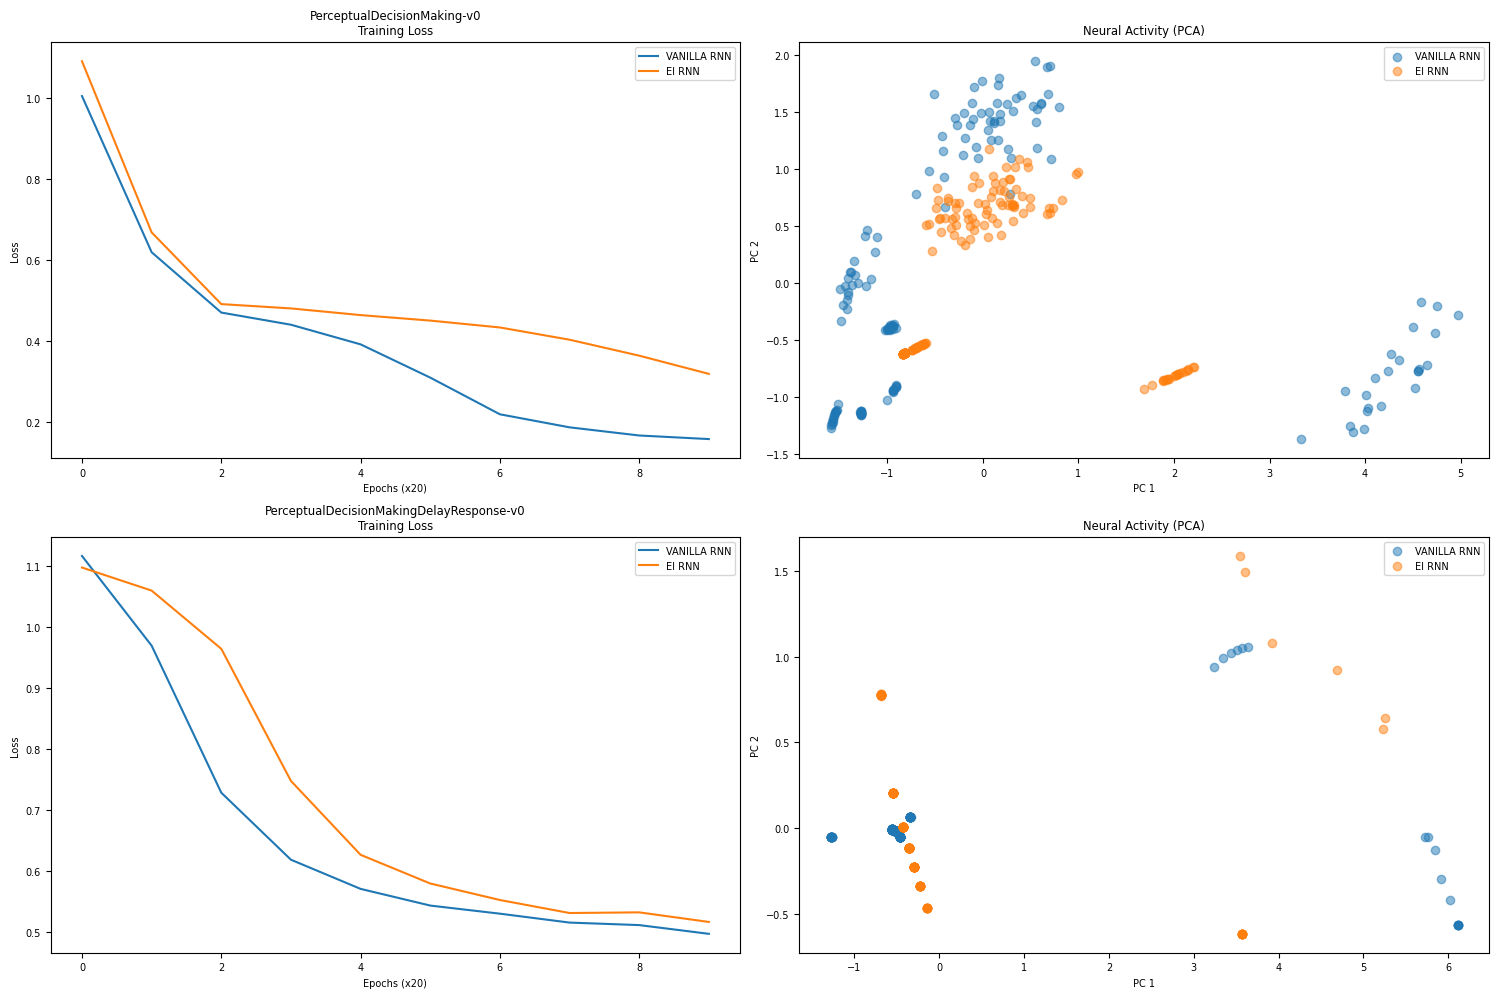

In [ ]:
"""
Lightweight Comparative Analysis of Vanilla RNN and EI-RNN
Optimized for basic computational resources
"""


@dataclass
class TaskConfig:
    """Simplified task configuration."""
    task_id: str
    timing: Dict
    dt: int = 20
    batch_size: int = 16  # Reduced batch size

class VanillaRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=False)
        self.readout = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(1, x.shape[1], self.hidden_size, device=x.device)
        output, hidden = self.rnn(x, hidden)
        return self.readout(output), hidden

class EIBasicRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, e_prop: float = 0.8):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.rec_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(self.e_size, output_size)

        mask = torch.ones(hidden_size, hidden_size)
        mask[self.e_size:, :] *= -1
        self.register_buffer('ei_mask', mask)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.input_layer.weight, -0.1, 0.1)
        nn.init.uniform_(self.rec_layer.weight, -0.1, 0.1)
        self.enforce_dale()

    def enforce_dale(self):
        with torch.no_grad():
            self.rec_layer.weight.data *= self.ei_mask
            self.rec_layer.weight.data = F.relu(self.rec_layer.weight.data)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(x.shape[1], self.hidden_size, device=x.device)
        outputs = []
        for t in range(x.shape[0]):
            hidden = torch.tanh(self.input_layer(x[t]) + self.rec_layer(hidden))
            output = self.output_layer(hidden[:, :self.e_size])
            outputs.append(output)
        return torch.stack(outputs), hidden

class ModelTrainer:
    def __init__(self, task_config: TaskConfig, hidden_size: int = 32):  # Reduced hidden size
        self.config = task_config
        self.hidden_size = hidden_size
        self.setup_environment()

    def setup_environment(self):
        env_kwargs = {'dt': self.config.dt, 'timing': self.config.timing}
        self.dataset = ngym.Dataset(self.config.task_id, env_kwargs=env_kwargs,
                                  batch_size=self.config.batch_size)
        self.env = self.dataset.env

    def train_model(self, model: nn.Module, num_epochs: int = 200) -> Tuple[List[float], float]:  # Reduced epochs
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        losses = []
        best_acc = 0

        for epoch in range(num_epochs):
            model.train()
            inputs, labels = self.dataset()
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = torch.from_numpy(labels).long().to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)
            outputs_flat = outputs.view(-1, outputs.shape[-1])
            labels_flat = labels.view(-1)
            loss = criterion(outputs_flat, labels_flat)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if isinstance(model, EIBasicRNN):
                model.enforce_dale()

            if epoch % 20 == 0:  # More frequent logging
                acc = self.evaluate_model(model, num_trials=10)  # Reduced evaluation trials
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Acc: {acc:.4f}')
                losses.append(loss.item())
                best_acc = max(best_acc, acc)

        return losses, best_acc

    def evaluate_model(self, model: nn.Module, num_trials: int = 10) -> float:  # Reduced evaluation trials
        model.eval()
        correct = 0
        total = 0
        device = next(model.parameters()).device

        with torch.no_grad():
            for _ in range(num_trials):
                inputs, labels = self.dataset()
                inputs = torch.from_numpy(inputs).float().to(device)
                labels = torch.from_numpy(labels).long().to(device)
                outputs, _ = model(inputs)
                _, predicted = outputs[-1].max(1)
                correct += (predicted == labels[-1]).sum().item()
                total += len(labels[-1])

        return correct / total

    def analyze_model(self, model: nn.Module, num_trials: int = 10) -> Dict:  # Reduced analysis trials
        model.eval()
        device = next(model.parameters()).device
        activities = []
        labels_list = []

        with torch.no_grad():
            for _ in range(num_trials):
                inputs, labels = self.dataset()
                inputs = torch.from_numpy(inputs).float().to(device)
                outputs, hidden = model(inputs)

                if isinstance(model, VanillaRNN):
                    activity = hidden.squeeze(0).cpu().numpy()
                else:
                    activity = hidden.cpu().numpy()

                activities.append(activity)
                labels_list.append(labels)

        activities = np.array(activities)
        activities_flat = activities.reshape(-1, activities.shape[-1])

        pca = PCA(n_components=2)
        activities_pca = pca.fit_transform(activities_flat)

        return {
            'activities_pca': activities_pca.reshape(activities.shape[:-1] + (2,)),
            'labels': np.array(labels_list),
            'explained_var': pca.explained_variance_ratio_
        }

def compare_models():
    tasks = [
        TaskConfig('PerceptualDecisionMaking-v0',
                  timing={'fixation': ('choice', [200, 400]),  # Simplified timing
                         'stimulus': ('choice', [200, 400])}),
        TaskConfig('PerceptualDecisionMakingDelayResponse-v0',
                  timing={'fixation': ('choice', [200, 400]),
                         'stimulus': ('choice', [200, 400]),
                         'delay': ('choice', [200])})  # Shorter delay
    ]

    results = {}
    for task in tasks:
        print(f"\nTraining on task: {task.task_id}")
        trainer = ModelTrainer(task)
        input_size = trainer.env.observation_space.shape[0]
        output_size = trainer.env.action_space.n

        task_results = {}
        for model_type in ['vanilla', 'ei']:
            print(f"\nTraining {model_type.upper()} RNN...")
            if model_type == 'vanilla':
                model = VanillaRNN(input_size, 32, output_size)  # Smaller network
            else:
                model = EIBasicRNN(input_size, 32, output_size)  # Smaller network

            losses, acc = trainer.train_model(model)
            analysis = trainer.analyze_model(model)

            task_results[model_type] = {
                'losses': losses,
                'accuracy': acc,
                'analysis': analysis
            }

        results[task.task_id] = task_results

    visualize_results(results)
    return results

def visualize_results(results: Dict):
    num_tasks = len(results)
    fig = plt.figure(figsize=(15, 5*num_tasks))

    for task_idx, (task_id, task_data) in enumerate(results.items()):
        # Loss plot
        plt.subplot(num_tasks, 2, task_idx*2 + 1)
        for model_type in ['vanilla', 'ei']:
            plt.plot(task_data[model_type]['losses'],
                    label=f'{model_type.upper()} RNN')
        plt.title(f'{task_id}\nTraining Loss')
        plt.xlabel('Epochs (x20)')
        plt.ylabel('Loss')
        plt.legend()

        # PCA plot
        plt.subplot(num_tasks, 2, task_idx*2 + 2)
        for model_type in ['vanilla', 'ei']:
            analysis = task_data[model_type]['analysis']
            activities_pca = analysis['activities_pca']
            plt.scatter(activities_pca[:, :, 0].flatten(),
                       activities_pca[:, :, 1].flatten(),
                       alpha=0.5, label=f'{model_type.upper()} RNN')
        plt.title('Neural Activity (PCA)')
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    start_time = time.time()
    results = compare_models()
    print(f"\nTotal execution time: {time.time() - start_time:.2f} seconds")

    print("\nFinal Results Summary:")
    for task_id, task_data in results.items():
        print(f"\n{task_id}:")
        for model_type in ['vanilla', 'ei']:
            data = task_data[model_type]
            print(f"\n{model_type.upper()} RNN:")
            print(f"Accuracy: {data['accuracy']:.4f}")
            print(f"Final Loss: {data['losses'][-1]:.4f}")